## Manual extractions of FRESCO sources

The notebook uses the lambda helper function to extract the spectrum of a specific source from the exposure files stored on Amazon S3.  The example below finds the nearest source to some user-specified coordinates from the [fresco-gdn-med-ir.cat.fits](s3://grizli-v2/HST/Pipeline/fresco-gds-med/Extractions/fresco-gdn-med-ir.cat.fits) catalog, extracts the 2D spectra and runs a dummy redshift fit.  It only downloads the files locally and doesn't send the output back to S3/RDS.

- The machinery still isn't really set up to extract a spectrum at an arbitrary position.  There has to be an entry in the catalog and associated segmentation image to extract the spectra.

- Requires grizli RDS DB credentials and AWS account configuration.

- The GitHub/codespace environment with dependencies initialized with `python==3.10`

    ```bash 
    $ pip install grizli[aws,jwst] msaexp
    ```



In [2]:
# Working directory and config files
import os

if os.path.exists('/workspaces/panoramic-jwst'):
    HOME = '/workspaces/panoramic-jwst/FRESCO'
    if not os.path.exists(HOME):
        os.makedirs(HOME)
else:
    HOME = os.getcwd()

if os.getenv('GRIZLI') is None:
    os.environ['GRIZLI'] = os.path.join(HOME, 'GRIZLI')

CONF = os.path.join(os.environ['GRIZLI'], 'CONF')
for path in [os.environ['GRIZLI'], CONF]:
    if not os.path.exists(path):
        os.makedirs(path)

# Clone GRISM_NIRCAM to $GRIZLI/CONF if necessary
os.chdir(CONF)
if not os.path.exists('GRISM_NIRCAM'):
    ! git clone https://github.com/npirzkal/GRISM_NIRCAM.git

# Clean up a bunch of unnecessary files that take up a lot of disk space
! rm -rf ./GRISM_NIRCAM/V[123]* ./GRISM_NIRCAM/V4/*back*fits

os.chdir(HOME)
print(f'HOME: {HOME}')
print(f"GRIZLI: {os.environ['GRIZLI']}")
print(f'CONF: {CONF}')


HOME: /workspaces/panoramic-jwst/FRESCO
GRIZLI: /workspaces/panoramic-jwst/FRESCO/GRIZLI
CONF: /workspaces/panoramic-jwst/FRESCO/GRIZLI/CONF


In [3]:
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np

from grizli.aws import db, lambda_handler
from grizli import utils

import grizli
print(f'grizli version:  {grizli.__version__}')

Set ROOT_PATH=/workspaces/panoramic-jwst/FRESCO
grizli version:  1.8.7


In [4]:
try:
    import grismconf
except ImportError:
    ! pip install "grismconf==1.32"

In [5]:
os.chdir(HOME)
os.getcwd()

'/workspaces/panoramic-jwst/FRESCO'

# Find source ID from the catalog close to a specified RA/Dec.

In [33]:
# Random source that hadn't been extracted previously
ra, dec = 189.16464, 62.2357
field = 'fresco-gdn-med'

if not os.path.exists(f'{field}-ir.cat.fits'):
    ! aws s3 cp s3://grizli-v2/HST/Pipeline/{field}/Extractions/{field}-ir.cat.fits .

cat = utils.read_catalog(f'{field}-ir.cat.fits')

this = utils.read_catalog(f"""# ra dec
{ra} {dec}""")

idx, dr = cat.match_to_catalog_sky(this)
id = cat['NUMBER'][idx][0]

print(f"Source id={id} is {dr[0]:.2f} from RA, Dec. = {ra:.6f}, {dec:.6f}")

                    


Source id=12346 is 0.14 arcsec from RA, Dec. = 189.164640, 62.235700


# Spectrum extraction

Specify a `field` and `id` for a source to extract, e.g., `field='fresco-gdn-med'` and `id=2709`.  If the spectrum of that source was already extracted, the `beams.fits` file will be downloaded from S3, e.g., from

```
s3://grizli-v2/HST/Pipeline/{field}/Extractions/{field}_{id:05d}.beams.fits
```

If the spectra of that source ID hadn't yet been extracted, the script knows how to download the individual `GrismFLT` exposure files and pull the 2D spectrum from them.   If you have enough disk space, you can keep all of the `GrismFLT` files around to avoid having to redownload them for a different source.

Handler type:  redshift_handler
{'s3_object_path': 'HST/Pipeline/fresco-gdn-med/Extractions/fresco-gdn-med_12346.beams.fits', 'clean': False, 'verbose': True, 'skip_started': False, 'run_fit': True, 'update_db': False, 'zr': [5.3, 5.4], 'working_directory': '/workspaces/panoramic-jwst/FRESCO'}
`import jwst` failed so JWST processing will not work!
Grizli version:  1.8.7
Disk info: Total = 32077.00 / Used = 21796.00 / Free = 8627.00
Working directory: /workspaces/panoramic-jwst/FRESCO
Initial file (1): GRIZLI
Initial file (2): files.txt
Initial file (3): fresco-gdn-med-ir.cat.fits
Initial file (4): fresco-gdn-med_12345.R30.fits
Initial file (5): fresco-gdn-med_12345.R30.png
Initial file (6): fresco-gdn-med_12345.beams.fits
Initial file (7): fresco-gdn-med_12345.log_par
Initial file (8): fresco-gdn-med_12345.stack.fits
Initial file (9): fresco-gdn-med_12345.stack.png
Initial file (10): fresco-gdn-med_12345.start.log
Initial file (11): fresco-gdn-med_27901.1D.fits
Initial file (12): fresc

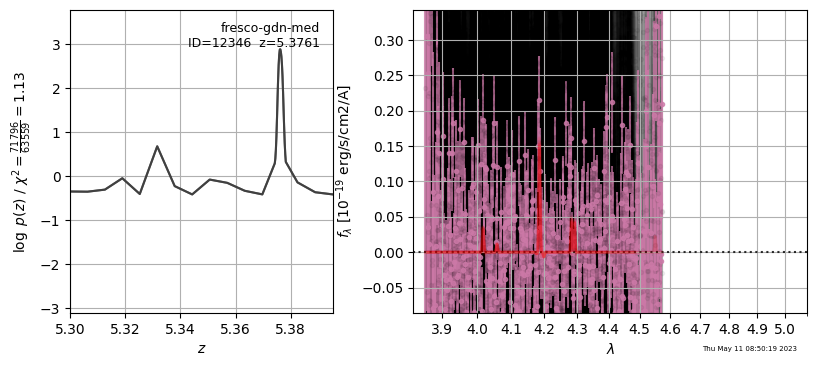

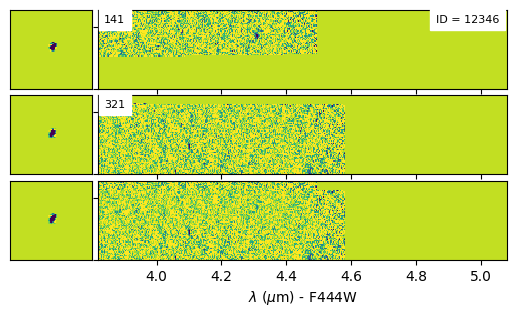

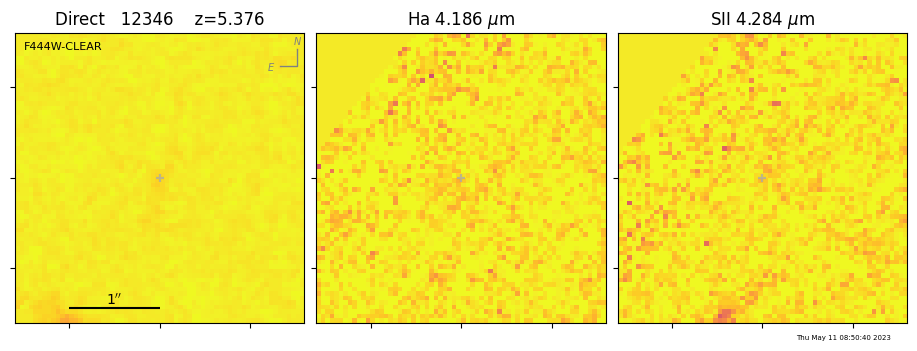

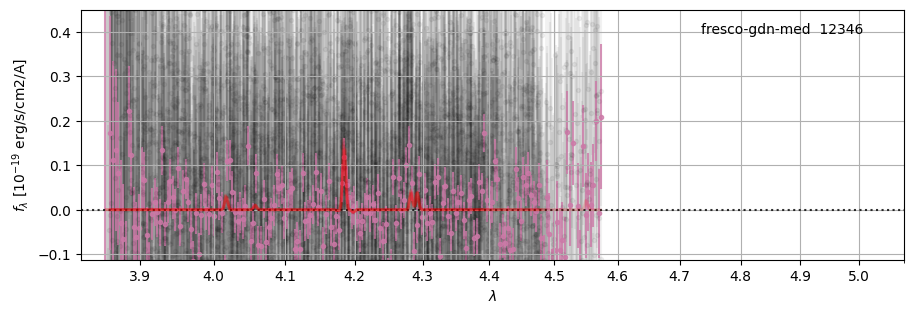

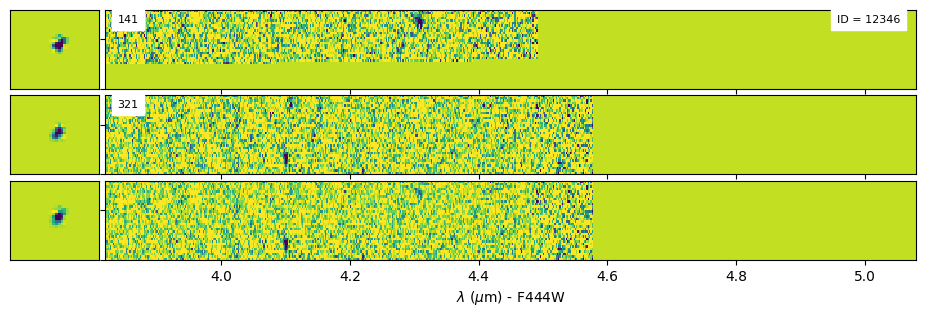

In [7]:
event = {
  "s3_object_path": f"HST/Pipeline/{field}/Extractions/{field}_{id:05d}.beams.fits",
  "clean": False,
  "verbose": True,
  "skip_started": False,
  "run_fit": True,
  "update_db": False,
  "zr": [5.3,5.4], # Dummy range for fitting redshifts
  "working_directory": HOME,
}

_ = lambda_handler.handler(event, {})

In [8]:
# If running out of disk space, delete GrismFLT files
! rm *wcs.fits *GrismFLT.*

## Demo of redshift fit of a previously-extracted source with Halpha at z=5.4

Handler type:  redshift_handler
{'s3_object_path': 'HST/Pipeline/fresco-gdn-med/Extractions/fresco-gdn-med_27901.beams.fits', 'clean': False, 'verbose': True, 'skip_started': False, 'run_fit': True, 'update_db': False, 'zr': [5.3, 5.4], 'working_directory': '/workspaces/panoramic-jwst/FRESCO'}
Grizli version:  1.8.7
Disk info: Total = 32077.00 / Used = 14858.00 / Free = 15564.00
Working directory: /workspaces/panoramic-jwst/FRESCO
Initial file (1): GRIZLI
Initial file (2): fresco-gdn-med-ir.cat.fits
Initial file (3): fresco-gdn-med_12345.R30.fits
Initial file (4): fresco-gdn-med_12345.R30.png
Initial file (5): fresco-gdn-med_12345.beams.fits
Initial file (6): fresco-gdn-med_12345.log_par
Initial file (7): fresco-gdn-med_12345.stack.fits
Initial file (8): fresco-gdn-med_12345.stack.png
Initial file (9): fresco-gdn-med_12345.start.log
Initial file (10): fresco-gdn-med_12346.1D.fits
Initial file (11): fresco-gdn-med_12346.1d.png
Initial file (12): fresco-gdn-med_12346.2d.png
Initial file 

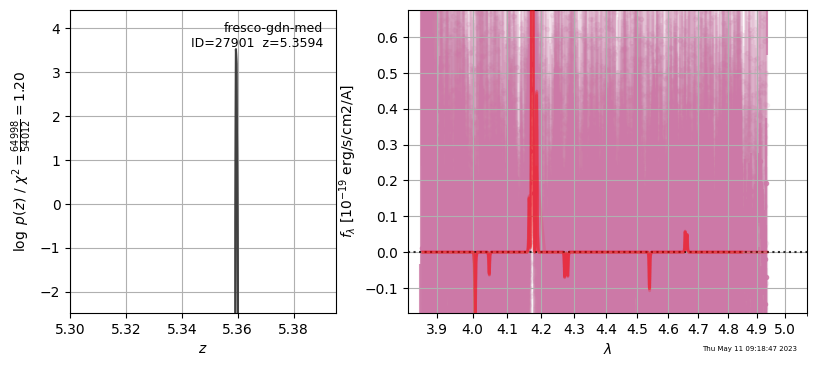

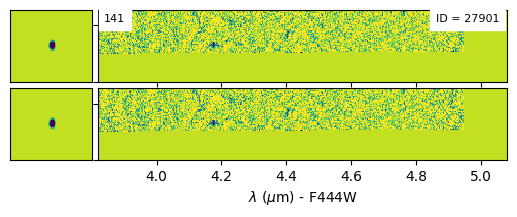

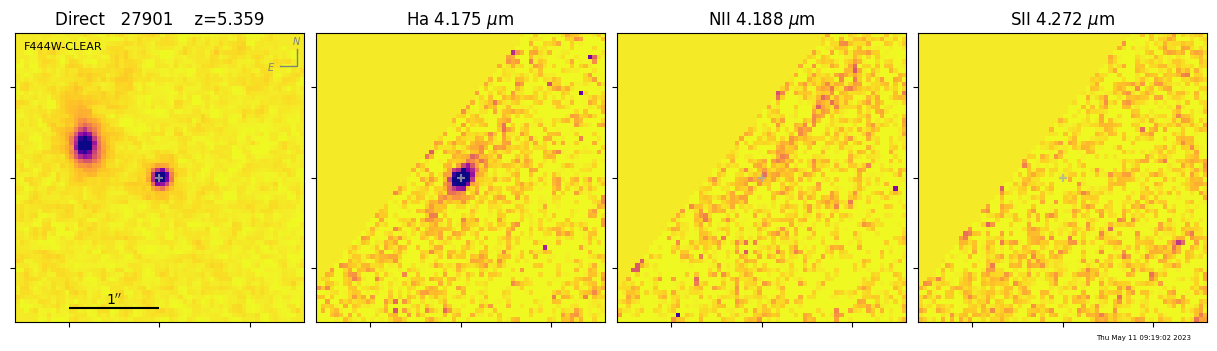

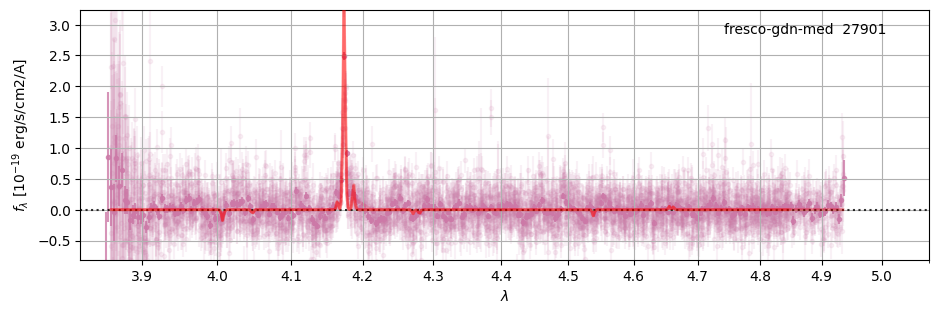

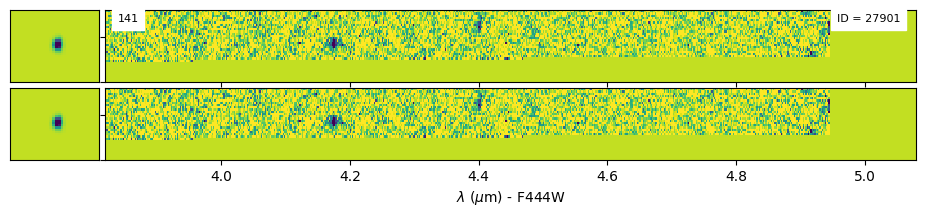

In [35]:
# Test source with a known H\alpha line

field = 'fresco-gdn-med'
id = 27901

event = {
  "s3_object_path": f"HST/Pipeline/{field}/Extractions/{field}_{id:05d}.beams.fits",
  "clean": False,
  "verbose": True,
  "skip_started": False,
  "run_fit": True,
  "update_db": False,
  "zr": [5.3,5.4], # Dummy range for fitting redshifts
  "working_directory": HOME,
}

_ = lambda_handler.handler(event, {})
